__Adaptive Pixelization__

In this tutorial, we'll introduce a new type of pixelization, called a VoronoiMagnification pixelization.

This pixelization doesn't use uniform grid of rectangular pixels, but instead an irregular grid 'Voronoi' pixels. So, why do we want to do that? Lets take another look at the rectangular grid, and think about its weaknesses.

In [ ]:
%matplotlib inline

from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.lens import lens_fit
from autolens.lens import lens_data as ld
from autolens.model.inversion import pixelizations as pix
from autolens.model.inversion import regularization as reg
from autolens.data.plotters import ccd_plotters
from autolens.model.inversion.plotters import inversion_plotters
from autolens.lens.plotters import lens_fit_plotters

This simulates the same the image we've fitted in the past few tutorials.

In [ ]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(150, 150), pixel_scale=0.05, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
        ),
    )

    source_galaxy = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.0, 0.0),
            axis_ratio=0.7,
            phi=135.0,
            intensity=0.2,
            effective_radius=0.2,
            sersic_index=2.5,
        ),
    )

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy, source_galaxy],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    return simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.05,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=1.0,
        add_noise=True,
    )

Lets quickly remind ourselves of the image and the 3.0" circular mask we'll use to mask it.

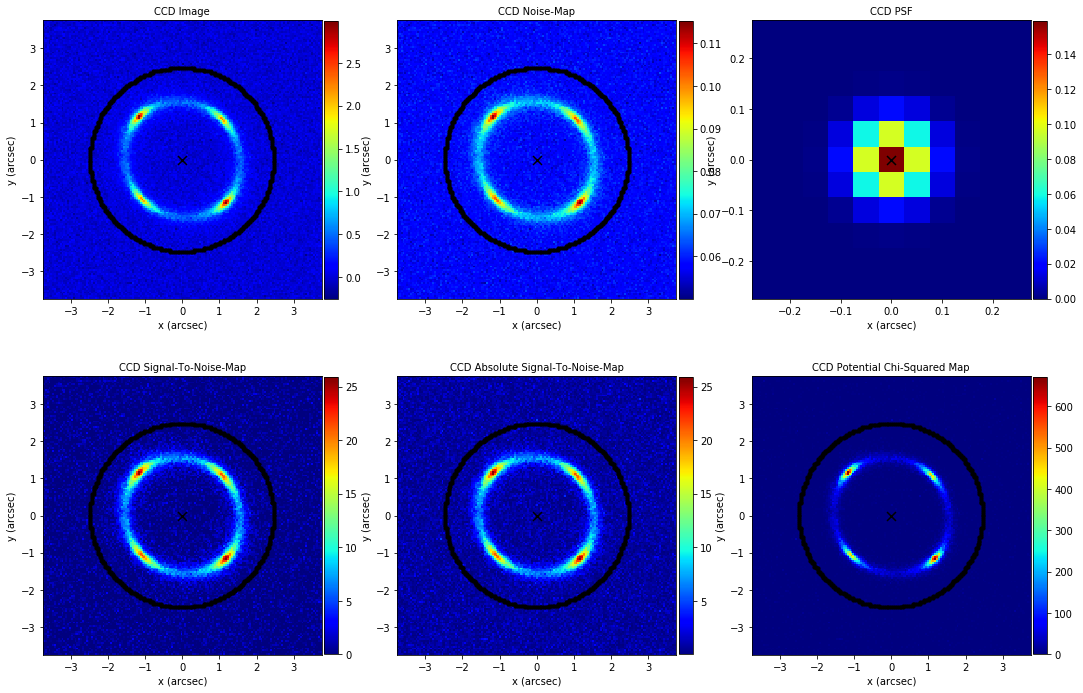

In [ ]:
ccd_data = simulate()

mask = msk.Mask.circular(
    shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, radius_arcsec=2.5
)

ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data, mask=mask)

The lines of code below do everything we're used to, that is, setup an image and its grid stack, mask it, trace it via a tracer, setup the rectangular mapper, etc.

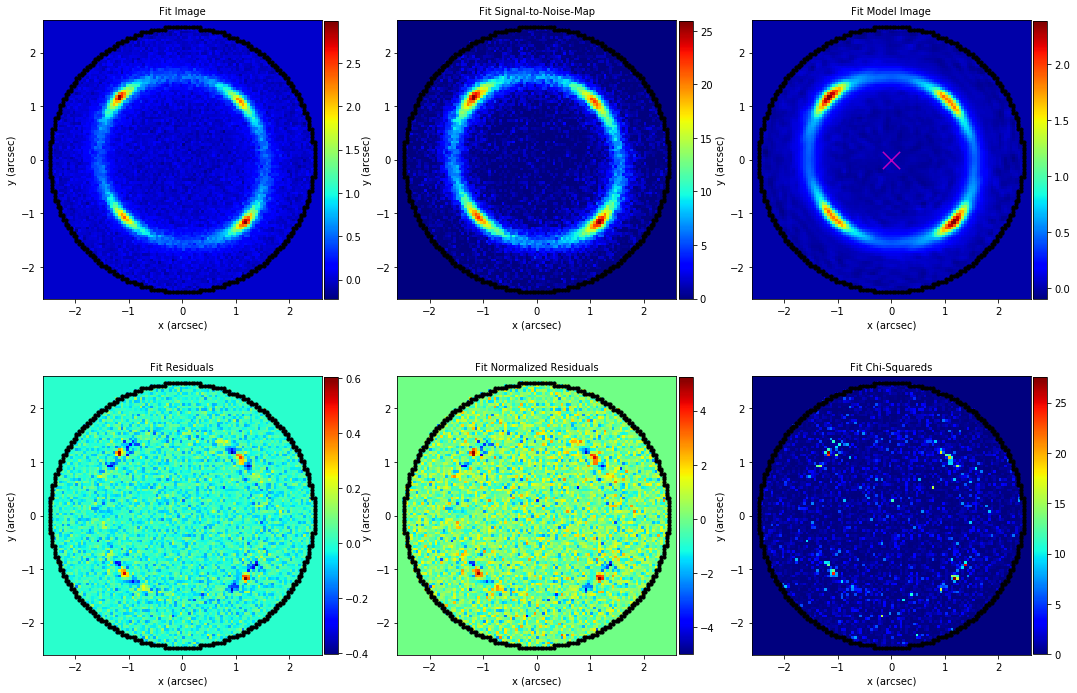

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
    ),
)

lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

source_galaxy = g.Galaxy(
    redshift=1.0,
    pixelization=pix.Rectangular(shape=(40, 40)),
    regularization=reg.Constant(coefficient=0.5),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy, source_galaxy],
    image_plane_grid_stack=lens_data.grid_stack,
    border=lens_data.border,
)

fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)


Okay, so lets think about the rectangular pixelization. Is it the optimal way to reconstruct our source? Are there features in the source-plane that arn't ideal? How do you think we could do a better job?

Well, given we're doing a whole tutorial on using a different pixelization to the rectangular grid, you've probably guessed that it isn't optimal. Infact, its pretty rubbish, and not a pixelization we should actually want to model many lenses with!

So what is wrong with the grid? Well, lets think about the source reconstruction.

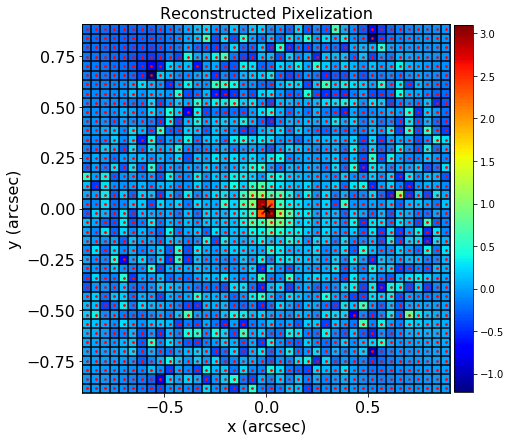

In [ ]:
inversion_plotters.plot_pixelization_values(
    inversion=fit.inversion, should_plot_centres=True
)

There is one clear problem - we are using just a small number of source pixels to reconstruct the source. Think about it - the majority of source pixels are located away from the source. By my estimate, we're using just 16 pixels (the central 4x4 grid) out of the 1600 pixels to actually fit the data! The remaining ~1500 pixels are doing *nothing* but fit noise.

This is a complete waste of processing, meaning that our analysis will take longer to run than necessary. However, more importantly, it means that our Bayesian regularization scheme is sub-optimal. In tutorial 4, we discussed how  the Bayesian evidence of the regularization wants to obtain the *simplest* source solution possible. That is, the solution which fits the data well, using the fewest source pixels. Clearly, we're dedicating a huge number of source pixels to doing *nothing*, making our source reconstruction more complex (and therefore of a lower evidence) than necessary.

If our pixelization could 'focus' its pixels where we actually have more data, e.g. the highly magnified regions of the source-plane, we could reconstruct the source using far fewer pixels. That'd be great both for computational efficiency and increasing the Bayesian evidence, and that is exactly what our Voronoi grid does.

To achieve this, we first compute an 'image-plane pixelization grid', which is a set of sparse coordinates in the image-plane that will be ray-traced to the source-plane and define the centres of our source-pixel grid. We compute this grid directly from a pixelization, by passing it a grid-stack.

In [ ]:
adaptive = pix.VoronoiMagnification(shape=(30, 30))

pixelization_grid = adaptive.pixelization_grid_from_grid_stack(
    grid_stack=lens_data.grid_stack
)

We can plot this grid over the image, to see that it is a coarse grid over-laying the image itself.

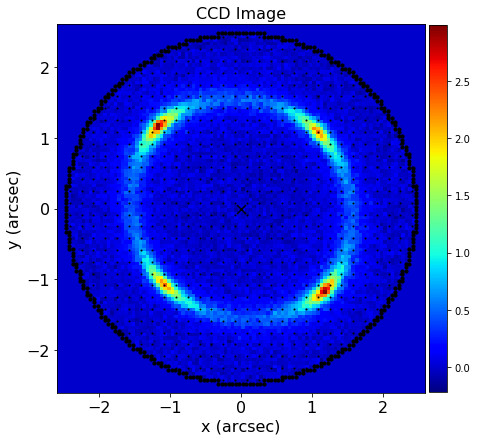

In [ ]:
ccd_plotters.plot_image(
    ccd_data=ccd_data,
    grid=pixelization_grid,
    mask=mask,
    zoom_around_mask=True,
    extract_array_from_mask=True,
)

Next, we can add this grid to the grid-stack we pass via the tracer. This means that the grid will be ray-traced like the regular-grid and sub-grids, such that in the source-plane we can use it to set our source-pixel centres.

In [ ]:
grid_stack_with_pixelization_grid = lens_data.grid_stack.new_grid_stack_with_grids_added(
    pixelization=pixelization_grid
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    pixelization=adaptive,
    regularization=reg.Constant(coefficient=0.5),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy, source_galaxy],
    image_plane_grid_stack=grid_stack_with_pixelization_grid,
)

print(
    tracer.source_plane.grid_stack.pixelization[0:10, :]
)  # <- this is our pixelization grid

[[ 0.87297158 -0.10635583]
 [ 0.85282458 -0.03721056]
 [ 0.8387447   0.02720028]
 [ 0.83145812  0.08795863]
 [ 0.83146753  0.14637056]
 [ 0.83899531  0.20389523]
 [ 0.85395425  0.26205174]
 [ 0.87595218  0.322317  ]
 [ 0.81080743 -0.3130126 ]
 [ 0.77426464 -0.22867036]]


If we look at the lens fit, we'll that our source-plane no longer uses rectangular pixels, but Voronoi pixels!

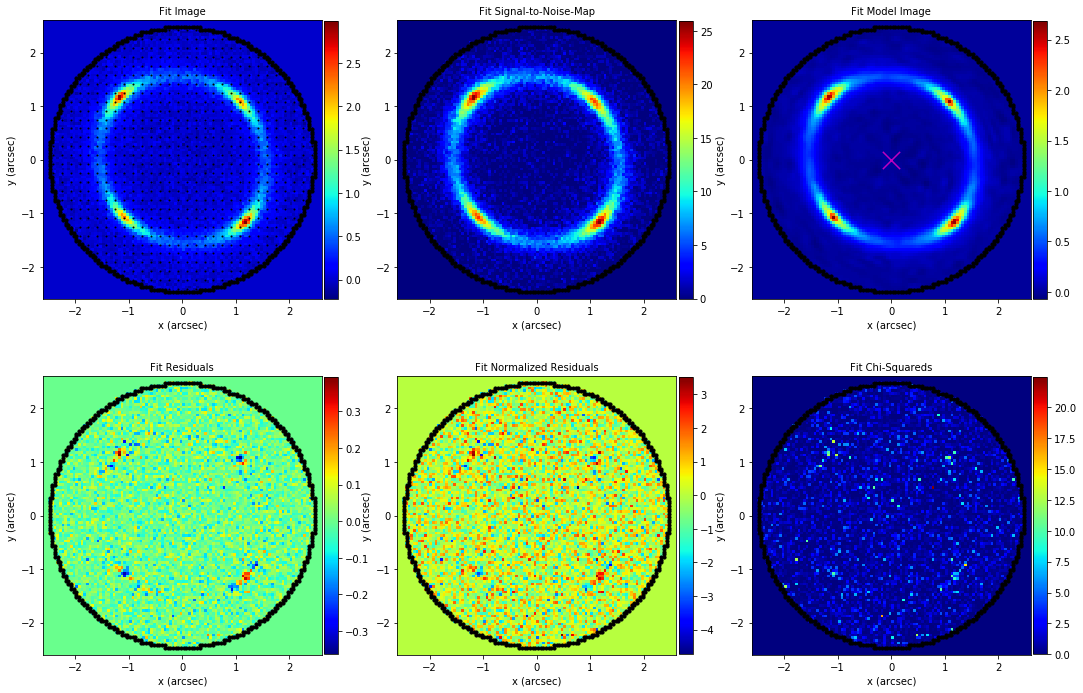

In [ ]:
fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit,
    should_plot_image_plane_pix=True,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

And we can take a closer inspection of the inversion itself.

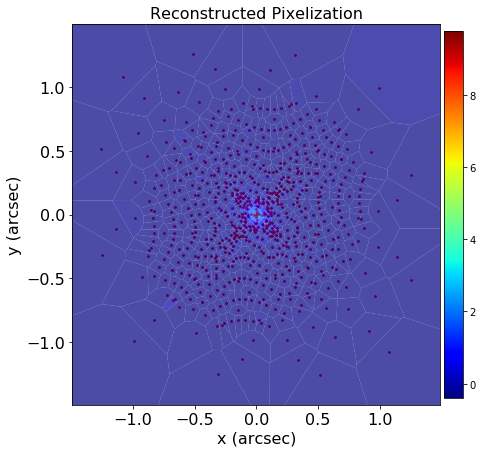

In [ ]:
inversion_plotters.plot_pixelization_values(
    inversion=fit.inversion, should_plot_centres=True
)

Clearly, this is an improvement. We're using fewer pixels than the rectangular grid (400, instead of 1600), but reconstructing our source is far greater detail. A win all around? It sure is.

I'll quickly mention regularization, too. On our rectangular grid, we regularized each source pixel with its 4 neighbors. That is, we compared their fluxes, summed the differences, and penalized solutions where the differences were large. For a Voronoi grid, we do the exact same thing, except we compare each source-pixel with all other source-pixels with which it shares a direct vertex. This means that different source-pixels may be regularized with different numbers of source-pixels, depending on how many neighbors are formed.

However, the Voronoi magnification grid is still far from optimal. There are still a lot of source-pixels effectively fitting noise, and it may be that we would achieve even better solutions if the central regions of the source were reconstructed using even more pixels. So, how do we improve on this? Well, you'll have to wait until chapter 5, when we introduce PyAutoLens's adaptive functionality, which has the umbrella term of 'hyper-fitting'.

In the mean time, you may wish to experiment with using both Rectangular and VoronoiMagnification grids to fit lenses, which can be easily achieve by changing the input pixeliation given to a pipeline.